<header style="padding: 4em 0 0em 0">
    <img src="http://brentyi.github.io/filestore/ai4all_logo.svg" style="width: 30em; height: auto; margin: 0;" />
    <h3 style="margin: 1em 0 0 0;">
        <strong>Graphs I</strong>
        <span style="color: #777">
        &nbsp;&blacksquare;&nbsp;
        Robotics, Summer 2020</span>
    </h3>
</header>

<hr style="border-top: 0.4em solid #eee;" />

In this notebook, we'll take a whirlwind tour of graphs and graph search algorithms.

Our core goals will be to:
1. Go from satellite images to two-dimensional NumPyA arrays
2. Think about the graph induced by cells we can visit.

<hr style="border-top: 0.4em solid #eee;" />

In [51]:
import numpy as np
from graph_helpers import visualize_single_channel, visualize_map

### 1. Maps to Matrix

<p>First, let's remember that we are taking a map like this:</p>
<img src="graph_assets/stanford.png" width=500 style="margin-left: 50px" />
<p>And we grid it up like this:</p>
<img src="graph_assets/stanford_grid.png" width=500 style="margin-left: 50px" />

This looks like a two dimensional array, right?

Let's create a rectangular array with zeros.

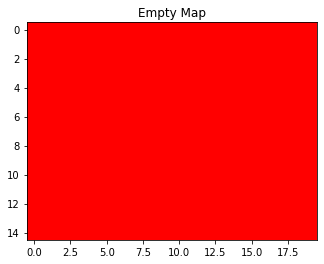

In [52]:
a = np.zeros((15, 20))
visualize_map("Empty Map", a)

Why is it red? Well, we want the value M[i, j] to encode something about that cell.

When we were working with images, each cell had 3 numbers (in the case of RGB or HSL), but now it has one.

We decide what that number means. Here we are saying, visualize that number as red!

In [53]:
b = np.zeros((15, 20))
b[0, 0] = 1

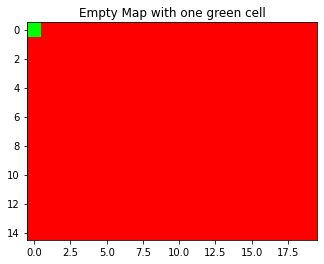

In [54]:
visualize_map("Empty Map with one green cell", b)

Here we are saying to visualize the number 1 as green!

The visualize map function takes an argument cmap which maps numbers to the colors we want to visualize them.

In fact, let's write a function that flips the colors!
  

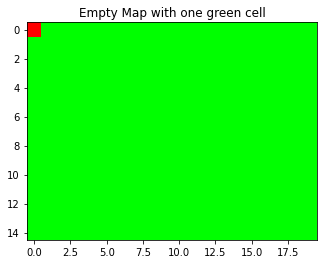

In [55]:
def flipped_cmap(x):
    if x == 0:
        return [0, 255, 0]
    else:
        return [255, 0, 0]

visualize_map("Empty Map with one green cell", b, cmap=flipped_cmap)

But let's not use that, because we want red to mean BAD, or danger, and green to mean GOOD, or safe.

### 2. Types of Cells

<p>Suppose the following cells, indicated with a red dot are "flyable":</p>
<img src="graph_assets/stanford_grid_flyable.png" width=500 style="margin-left: 50px" />


Let's visualize this flyable zone as green, and the unflyable as red

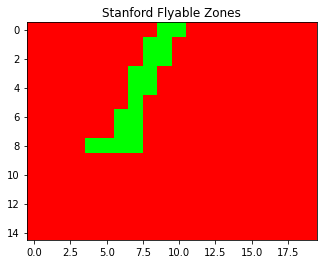

In [56]:
c = np.zeros((15, 20))
c[0, 9:11] = 1
c[1, 8:10] = 1
c[2, 8:10] = 1
c[3, 7:9] = 1
c[4, 7:9] = 1
c[5, 7:8] = 1
c[6, 6:8] = 1
c[7, 6:8] = 1
c[8, 4:8] = 1
visualize_map("Stanford Flyable Zones", c)

### 3. Constructing the graph


<p>Since we can only fly in between flyable cells, we are going to think about a graph!<p>
<img src="graph_assets/stanford_grid_flyable_connected.png" width=500 style="margin-left: 50px" />

Let's get the adjacency matrix 

In [57]:
def adjacency_matrix(M, flyable=1):
    """Visualize a 2D array using matplotlib.
    All inputs values should be normalized 0.0-1.0.

    Args:
        title (str): Name of image we're visualizing.
        image (np.ndarray): Image we're visualizing. Shape should be `(rows, cols)`.
    """
    m, n = M.shape
    k = m * n
    A = np.zeros((k, k))
    
    def idx(i, j):
        return i * m + j
    
    for i in range(0, m):
        for j in range(0, n):
            
            # check up
            if i != 0 and M[i, j] == flyable and M[i-1, j] == flyable:
                A[idx(i, j), idx(i-1, j)] = 1.
                    
            # check left
            if j != 0 and M[i, j] == flyable and M[i, j-1] == flyable:
                A[idx(i, j), idx(i, j-1)] = 1.
            
            # check down
            if i != m-1 and M[i, j] == flyable and M[i+1, j] == flyable:
                A[idx(i, j), idx(i+1, j)] = 1.
               
            # check right
            if j != n-1 and M[i, j] == flyable and M[i, j+1] == flyable:
                A[idx(i, j), idx(i, j+1)] = 1.

    return A    

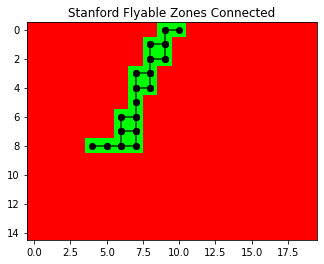

In [58]:
A = adjacency_matrix(c)
visualize_map("Stanford Flyable Zones Connected", c, A=A)

We can also visualize the adjacency matrix itself as a black and white image; white is where there is a one. 

Let's use the cv_helpers `visualize_single_channel` function.

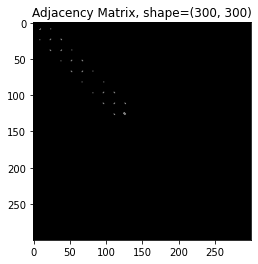

In [11]:
visualize_single_channel("Adjacency Matrix", A)

### 4. Finding Neighbors

Now let's write a function that get's the neighbors of vertices

In [59]:
def neighbors(A, i):
    """Get the neighbors of vertex `i`
    
    Args:
        A (np.ndarray): Adjacency matrix
        i (int): vertex we care about.
    """
    assert len(A.shape) == 2
    assert A.shape[0] == A.shape[1]
    
    # we have k vertices
    k = A.shape[0]
    
    # ~~START DELETE~~
    return [j for j in range(k) if A[i, j] == 1] 
    # ~~END DELETE~~

Does vertex 0, the top left have any neighbors?

In [60]:
neighbors(A, 0)

[]

Does vertex 24?

In [61]:
neighbors(A, 24)

[9, 23, 39]

### 5. Let's talk about Queues

For us, a queue is just a list:

In [62]:
queue = []

Append (or push) to the queue

In [63]:
queue.append(1)
queue.append(2)
queue

[1, 2]

Remove (or pop) from the queue

In [64]:
elem = queue[0]
queue = queue[1:]
print(f"popped {elem} from queue which is now {queue}")

popped 1 from queue which is now [2]


In [65]:
elem = queue[0]
queue = queue[1:]
print(f"popped {elem} from queue which is now {queue}")

popped 2 from queue which is now []


What happens if we pop from a queue when it's empty?

In [66]:
elem = queue[0]
queue = queue[1:]

IndexError: list index out of range

So in general, we might need to check



In [67]:
if len(queue) > 0:
    print("can pop")
else:
    print("can't pop")

can't pop


### 6. Search

In [68]:
def breadth_first_search(A, start, goal):
    
    # k is the number of nodes
    k = A.shape[0]
    # we will start our search at start
    q = [start]

    C = np.inf * np.ones((k, k))
    seen = {}
    
        
    def final_path(end):
        p = [end]
        nextt = froms[end]
        p.append(nextt)
        while nextt != start:
            nextt = froms[nextt]
            p.append(nextt)

        p.reverse()
        return p
    
    while len(q) > 0:
        current = q[0]
        seen[current] = True
        q = q[1:]
        
        for n in neighbors(A, current):
            if n not in seen:
                q.append(n)
                froms[n] = current
                if n == goal:
                    return final_path(n)
                
    raise Exception("no path to goal")